- reducció de dimensionalitat, volem reduir el tamany de les dimensions mirant de perdre el mínim de info possible, 
- que es diferencia del feature selection
- la diferencia és: reducció dimensionalitat és transportar les dades en un altre espai i en aquest altre espai els eixos són unes altres. Feature selection eliminim de les variables originals i mirem si el model millora o no. reducció de dimensionalitat eliminem columnes de l'espai que hem transformat les dades. 
- per reducció dimensionalitat: 
    - projecció: cada nou eix és multiplicar per la matriu de rotació. els nous eixos són combinacions lineals dels eixos anteriors. no sabem ven bé que són. les que queden al final, les podem treure, perque aporten menys. Projecció si que es una combinació lineal.
    - embedding: fer-ho amb una nn. Acabarem tenint una taula amb els vectors de sortida (el embeding que ha fet la xarxa). no tenim nom. i aquestes no són una combinació lineal.
- ---
- dataset original: dim = m
- feature selection: dim = m -3
- projecció: dim = m, però reorientem els eixos que hi han columnes que no aporten informació de m a 1,2,3 menys (principal components)
- ---
- descarta els que són més perpendiculars a les dades
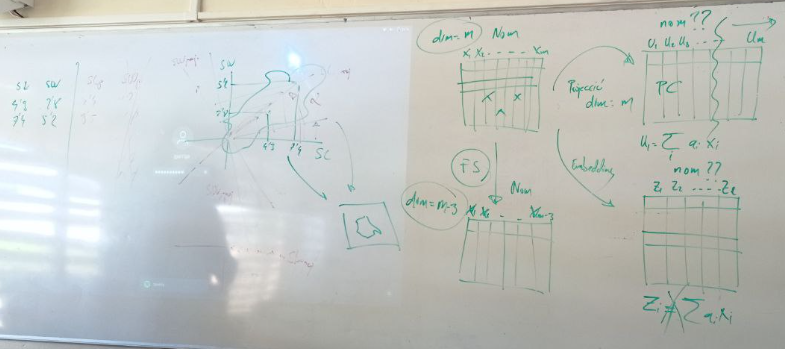

- com és que podem fer la reducció i encara generar els digits bé: 
- Si tenim un dígit dins de 28x28px. Hi ha pixels que són blancs, per tant són dimensions que no aporten dimensions. 
- Els del voltant en la majoría estàn buits.

### PCA example

This example shows how PCA can help computing a low dimensional kernel density estimation (KDE) to learn a generative model for a dataset. With this generative model in place, new samples can be drawn. These new samples reflect the underlying model of the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

#### load dataset

In [3]:
import pickle

In [4]:
with open('../Dades/mnist_joan/mnist_784.pkl', 'rb') as pkl:
    mnist = pickle.load(pkl)

- digits are images of 784 pixels (size: 28x28)

In [5]:
df = mnist.data
df.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### examples

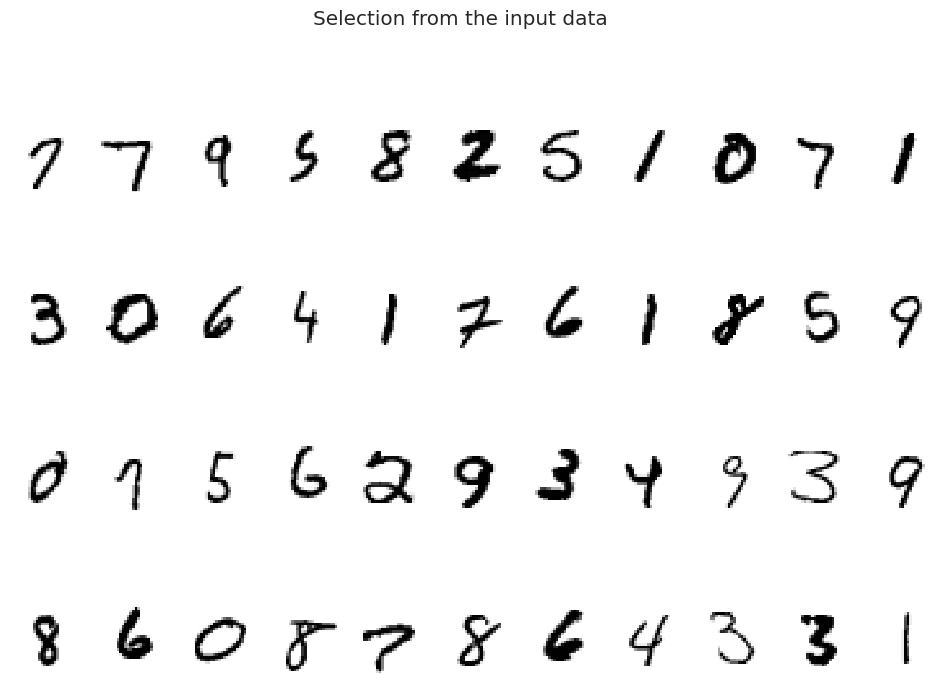

In [6]:
fig, axs = plt.subplots(4, 11, subplot_kw = dict(xticks=[], yticks=[]), figsize = (12, 8))
fig.suptitle("Selection from the input data")
for i, axi in zip(np.random.randint(0, df.shape[0], 44), axs.flatten()):
    im = axi.imshow(
        df.iloc[i, :].to_numpy().reshape((28, 28)), cmap = plt.cm.binary, interpolation = "nearest"
    )
    #im.set_clim(0, 256)

- KNN: hem de calcular 700 distancies per cada dígit del dataset, 2000M de distancies amb cada distancia de 784 components, té un cost computacional molt gran. 
- Qualsevol tipus de model, hem d'aplicar una reducció de dimensionalitat.
- Fem projecció a N dimensions, en aqeust cas 10.
- Fer el PCA, és una classe de sklearn.
- PCA: principal component analysis. Troba la matriu i fa la rotació, com el feature selection. Si una cosa es area i preu, quan ho convertim ja no és area ni preu, serà una barreja de les dues coses. 
- No es que directament les redueixi i elimini, sino que les combina i elimina les combinacions que no aporten. en un feature selection no, ens ho estem carregant directament. 

#### project the 784-dimensional data to a lower dimension

In [7]:
dims = 85

- whiten: és un parametre que per defecte està a false i ...

In [8]:
pca = PCA(n_components = dims, whiten = False)
data = pca.fit_transform(df)

In [9]:
data.shape

(70000, 85)

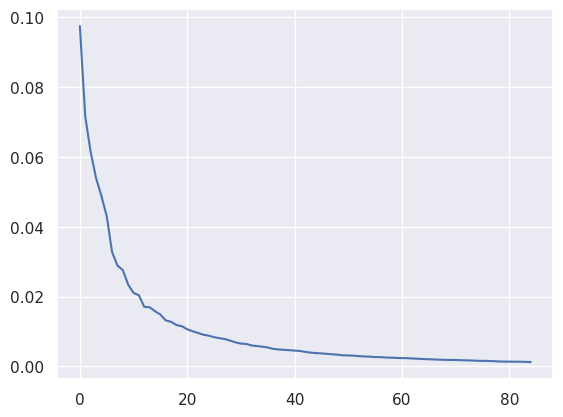

In [10]:
plt.plot(pca.explained_variance_ratio_);

- Agafem la matriu i fem el fit i ell calcula la matriu que fa la rotació. 
- Ara et passem unes noves dades i les multipliques per i retorna les transformades. 
- això és un fit transform. 
- retorna les dades amb les components.
- 70000 exemples només amb 10 dimensions. Retorna només les 10 primeres. 
- ---
- hi ha la funció que ens ensenya la informació que perdem. Que diu la quantitat de variança que explica cada un dels nous eixos.
- primera un 10%, segona ...
- cada vegada aporten menys informació.
- a partir de la 10, ja no aporten gairabé res. 

#### Evaluem com de bo és això que hem fet
- mostrejem a partir de una distribució conjunta. 
- Generem noves dades amb les dades projectades (10 dimensions)
- El parametre de n components, podem dir 10, 50, però no sabem quantes dimensions ens interessa conservar. 

#### compute the low-D join distribution

In [11]:
kde = KernelDensity(kernel = 'gaussian', bandwidth = 1).fit(data)

#### sample 44 new points from the data
- això són digits projectats. 
- si els volem pintar, el shem de convertir a 784 dim.
- proccès invers (multiplicar per la inversa de la matriu).
- les tindrem a l'espai original.

In [12]:
new_data = kde.sample(44, random_state = 0)

In [13]:
new_data.shape

(44, 85)

- Fem la inversa:

In [14]:
new_data = pca.inverse_transform(new_data)

In [15]:
new_data.shape

(44, 784)

#### plot resampled digits

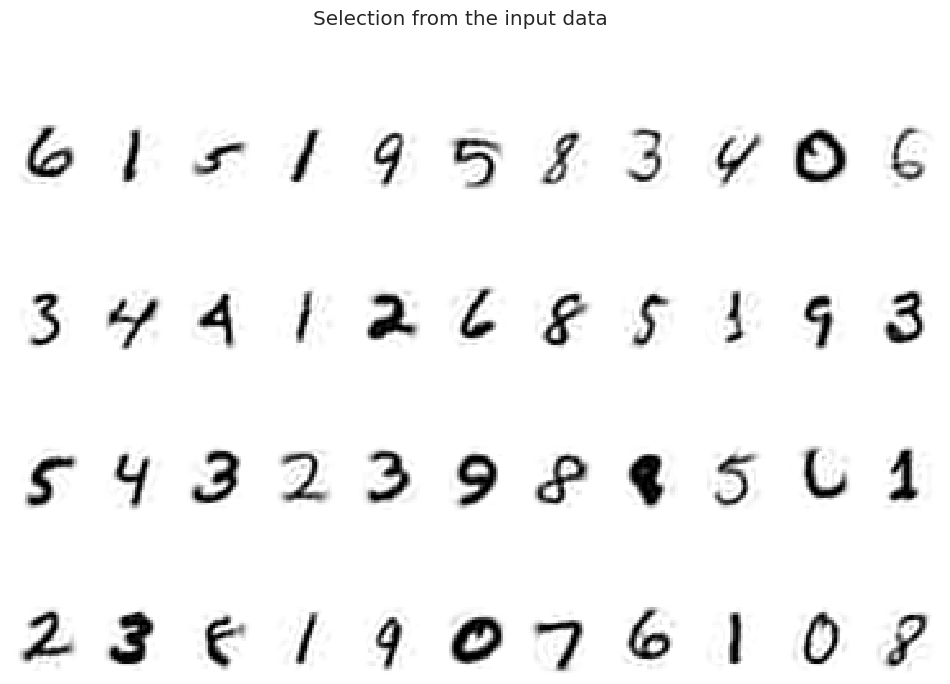

In [16]:
fig, axs = plt.subplots(4, 11, subplot_kw = dict(xticks=[], yticks=[]), figsize = (12, 8))
fig.suptitle("Selection from the input data")
for i, axi in enumerate(axs.flatten()):
    im = axi.imshow(
        new_data[i].reshape((28, 28)), cmap = plt.cm.binary, interpolation = "nearest"
    )
    im.set_clim(0, 256)

- Hem perdut algo de informació però es veu prou bé.
- Podem probar der fer la reducció a 20, 30, 40, 100. sería canviar el dims.
- Millora però encara passen coses rares, emulen els digits fets a mà.

#### PCA scree plot
- Scree = baixada de muntanya plena de pedres perque abans hi havia gel. 
- sempre va avall


In [17]:
def scree_plot(pca, expVar = 1):
    dims = np.where(np.cumsum(pca.explained_variance_ratio_) <= expVar)[0][-1]
    _, axs = plt.subplots(1, 2, figsize = (12, 5))    
    axs[0].set_ylabel("Explained Variance")
    axs[0].set_xlabel("#dims")
    axs[0].set_title("Explained Variance dims = %3d" %(pca.n_components_ if dims is None else dims))
    axs[0].set_ylim(0, max(pca.explained_variance_))
    axs[0].axhline(y = 1,color = 'b', linestyle = '--')
    axs[0].plot(pca.explained_variance_[:dims],'bo-')
    axs[1].set_ylabel("Explained Variance Ratio")
    axs[1].set_xlabel("#dims")
    axs[1].set_title("Explained Variance %6.4f" %np.cumsum(pca.explained_variance_ratio_[:dims])[-1])
    axs[1].set_ylim(0, 1)
    axs[1].axhline(y = 1,color = 'b', linestyle = '--')
    axs[1].plot(np.cumsum(pca.explained_variance_ratio_[:dims]),'bo-')

In [18]:
%%time
pca_mle = PCA(n_components = 'mle', whiten = False).fit(df)

CPU times: user 1min 39s, sys: 157 ms, total: 1min 39s
Wall time: 1min 39s


- si li posem el 0,algo que es el % de variança que volem conservar, ell va contant quantes compoenntes s'ha d'ha de quedar per explicar el 50% de la variabilitat de les dades
- ---
- ens podem pensar que el 90% es molt, pero no ho sabem. 
- el parametre `mle` es per tenir la màxima versemblança. es un mètode estadístic que ens diu lo millor, estem conservant practicament el 100% de la informació
- Això ja tarda més perquè fa molts pca (és més complex) pero bueno
- ---
- Amb 711 tenim el 100%
- Si vull el 90% quantes dimensions. són 85 (el segon plot)

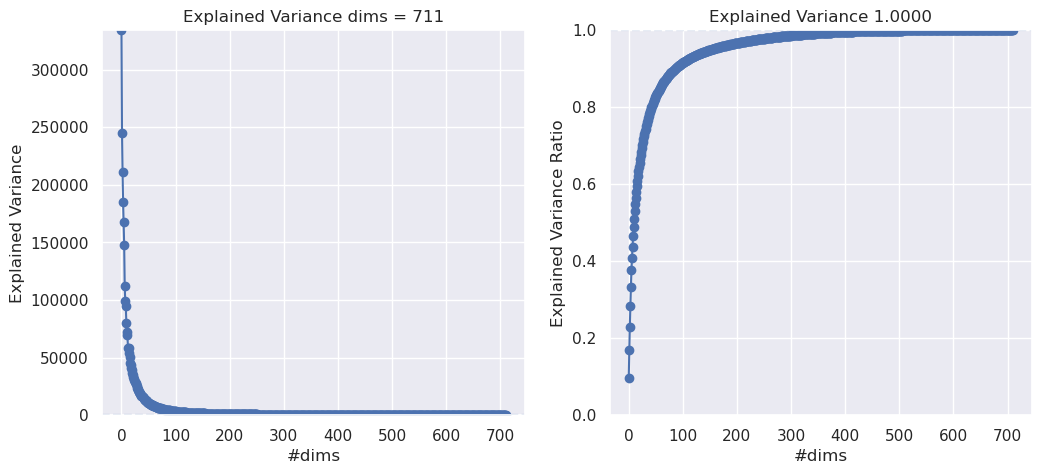

In [19]:
scree_plot(pca_mle)

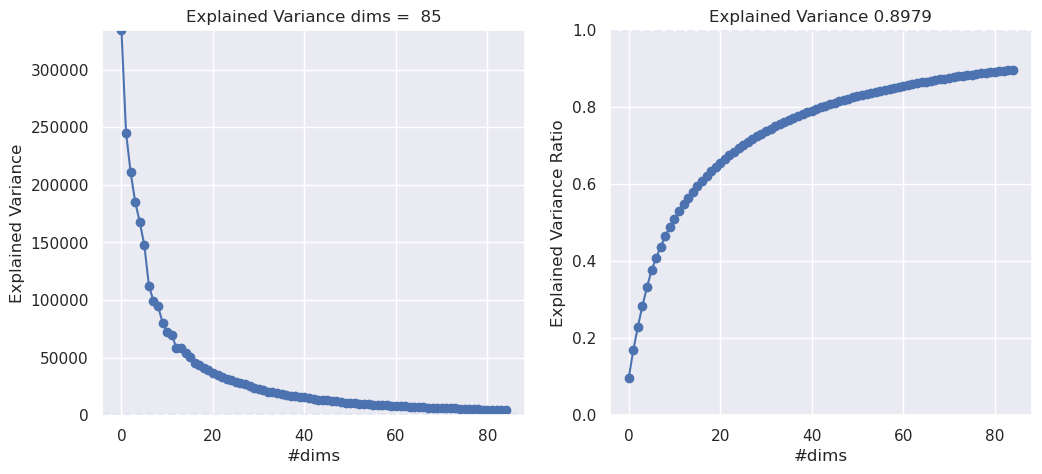

In [20]:
scree_plot(pca_mle, expVar = .9)

- abans hem fet una reducció 10, 50, amb una mica més estem al 90%

- lu interessant és trobar la estructura de les dades